## Imports

In [72]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
from skimage.util import img_as_float
from scipy import ndimage
#from shapely.geometry import Point, Polygon

img = io.imread('images/bat.tif')

## Paramètres

In [73]:
taille = 35
rho = 0.6
k = 10

## Prétraitement de l'image

Text(0.5, 1.0, 'Image prétraitée')

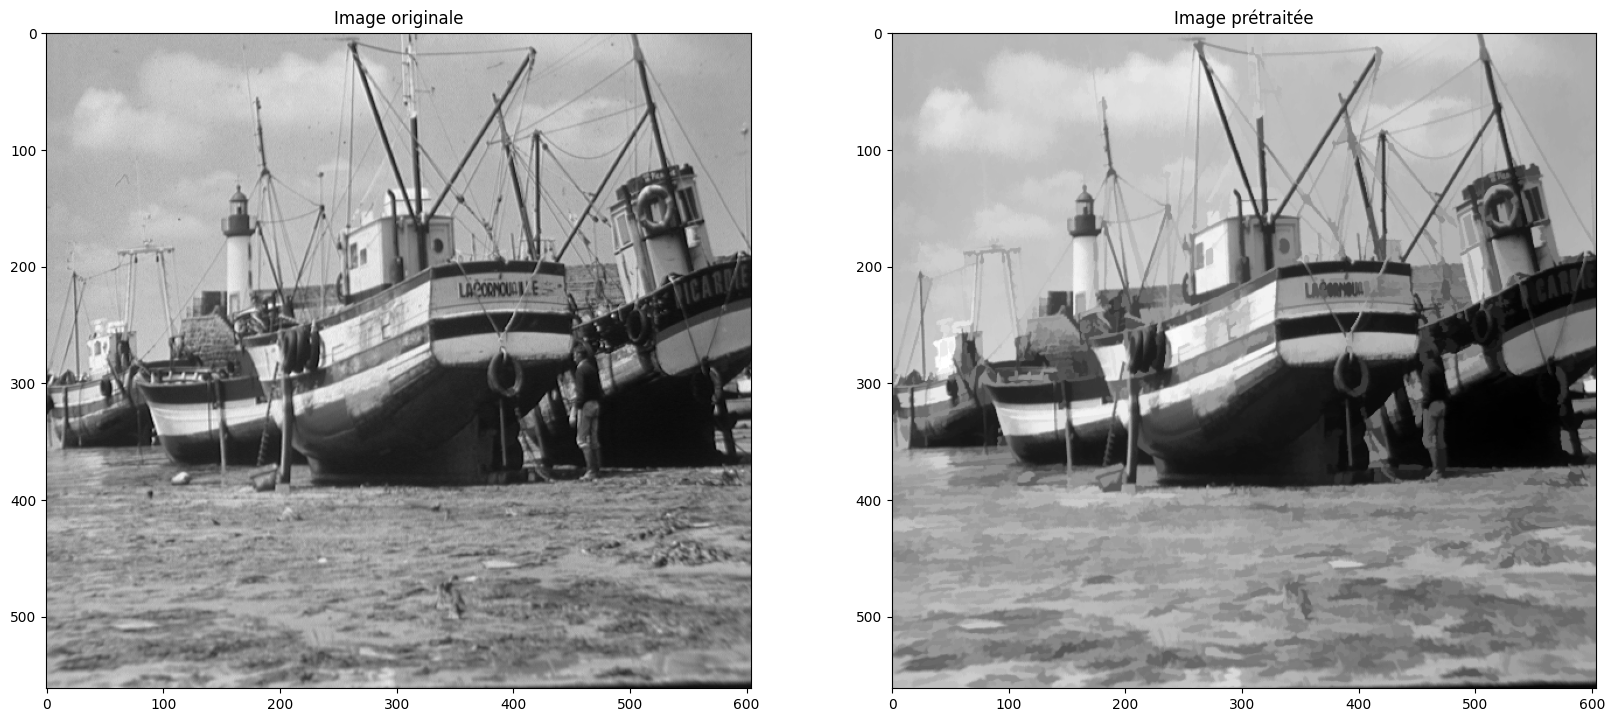

In [74]:
def pretraitement_image(img,taille):
    im = morpho.area_opening(img, area_threshold= taille*taille/16)
    im = morpho.area_closing(im, area_threshold= taille*taille/16)
    return im

im = pretraitement_image(img,taille)
fig,ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(im,cmap = "gray")
ax[1].set_title('Image prétraitée')

## Gradient morphologique

Text(0.5, 1.0, 'Gradient morphologique')

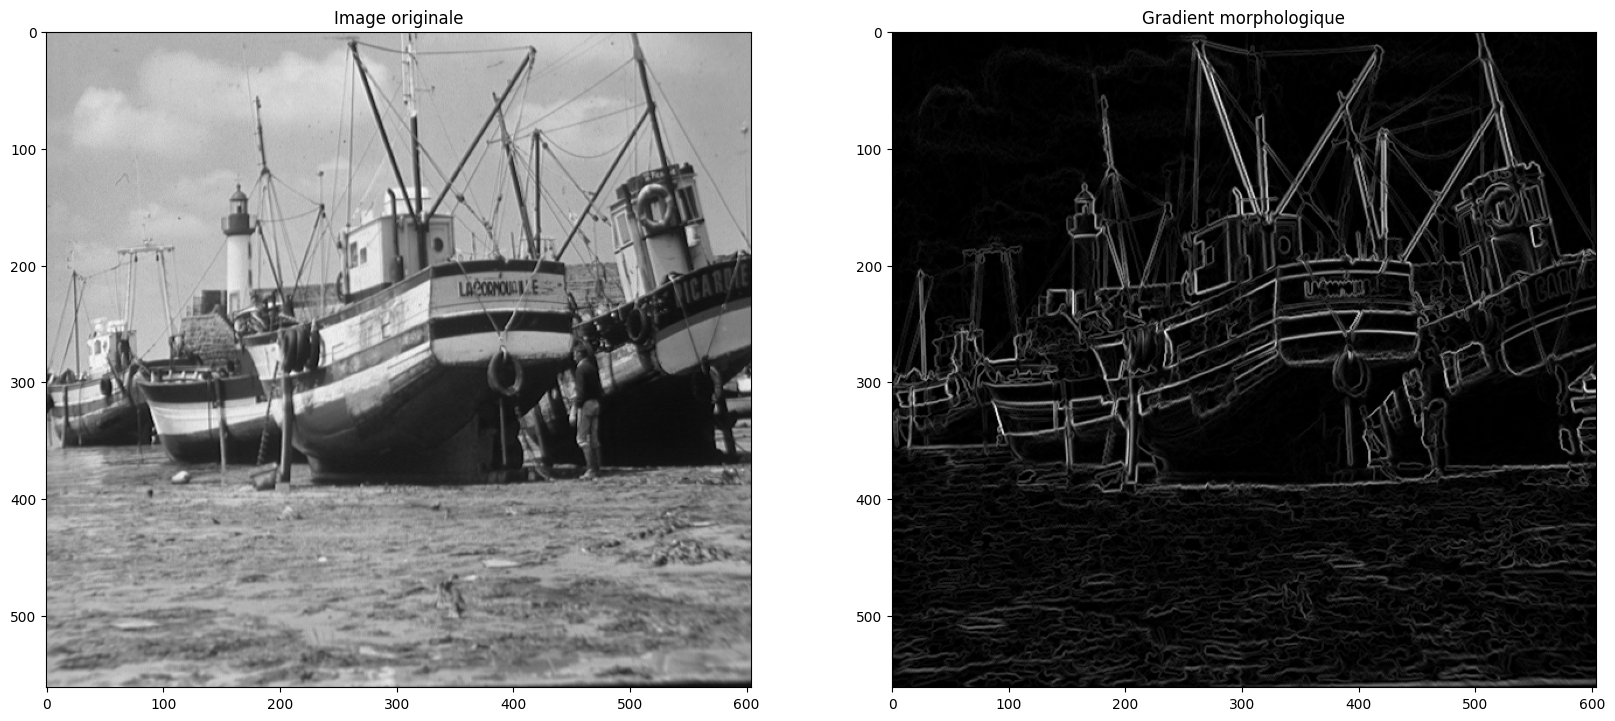

In [75]:
def gradmorpho(img):
    se = morpho.disk(1)
    morpho_grad = morpho.dilation(img,se) - morpho.erosion(img, se)

    return morpho_grad

grad_morpho = gradmorpho(im)

fig,ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(grad_morpho,cmap = "gray")
ax[1].set_title('Gradient morphologique')

## Cellules hexagonales

#### Calcul des centres des hexagones

In [76]:
def calcul_hexa_centers(img,taille):
    colonnes, lignes = img.size
    hexa_centers = []
    p_horizontal=3*taille*0.5
    p_vertical=np.sqrt(3)*taille
    I = int(colonnes/p_horizontal) + 2 #I est le nombre de centres par ligne
    J = int(lignes/p_vertical) + 2 #J est le nombre de centres par colonne
    for i in range(I):
        for j in range(J):
            if i%2==0:
                hexa_centers.append((int(i*p_horizontal) ,int(j*p_vertical)))
            else:
                hexa_centers.append((int(i*p_horizontal),int((j*p_vertical)+p_vertical/2)))
    return hexa_centers

#### Calcul des sommets d'un hexagone

In [77]:
# rho est le facteur d'homothétie, donc la nouvelle taille = t*rho
def hexa_sommets(centre, t, rho):
    x,y = centre
    taille= t*rho
    return [(x+taille,y),
            (x+(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-taille,y),
            (x-(taille/2),y-(taille*np.sqrt(3)/2)),
            (x+(taille/2),y-(taille*np.sqrt(3)/2))
            ]

Text(0.5, 1.0, 'taille=25, rho=2/3')

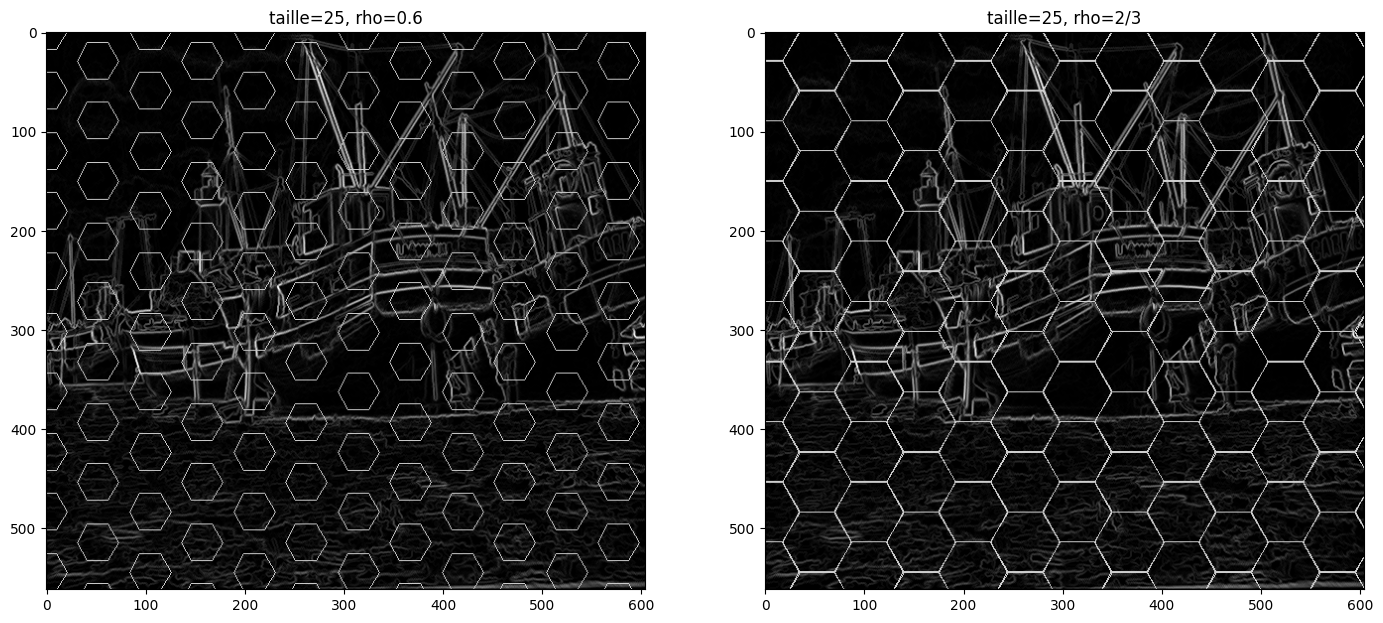

In [78]:
# Cellule de code pour vérifier que les hexagones sont corrects
def hexagon_grid(img, taille, rho):
    img_grid = img.copy()
    draw = ImageDraw.Draw(img_grid)
    hexa_centers = calcul_hexa_centers(img,taille)

    for c in hexa_centers:
        p = hexa_sommets(c, taille, rho)
        draw.polygon((p),outline="gray")

    return img_grid

im = Image.fromarray(np.uint8(grad_morpho))
hexa2 = hexagon_grid(im,taille,rho)
hexa = hexagon_grid(im,taille,1)
fig,ax = plt.subplots(1,2,figsize=(17,17))
ax[0].imshow(hexa2, cmap='gray')
ax[0].set_title('taille=25, rho=0.6')
ax[1].imshow(hexa, cmap='gray')
ax[1].set_title('taille=25, rho=2/3')

## Sélection des points dans les cellules

On approxime l'hexagone par son cercle inscrit (cf. vidéo)

In [79]:
def point_dans_hexagon(centre,point,taille):
    x,y = point[0]-centre[0],point[1]-centre[1]
    distance = math.sqrt((x**2)+(y**2))
    if distance <= np.sqrt(3)*taille/2:
        return True
    else:
        return False

In [80]:
def extract_hex_points(centre,taille):
    hex=[]
    for x in range(-taille-1,taille+1):
        for y in range(-taille-1,taille+1):
            if point_dans_hexagon(centre,(centre[0]+x,centre[1]+y),taille):
                hex.append((centre[0]+x,centre[1]+y))
    return hex

Text(0.5, 1.0, 'Cellules')

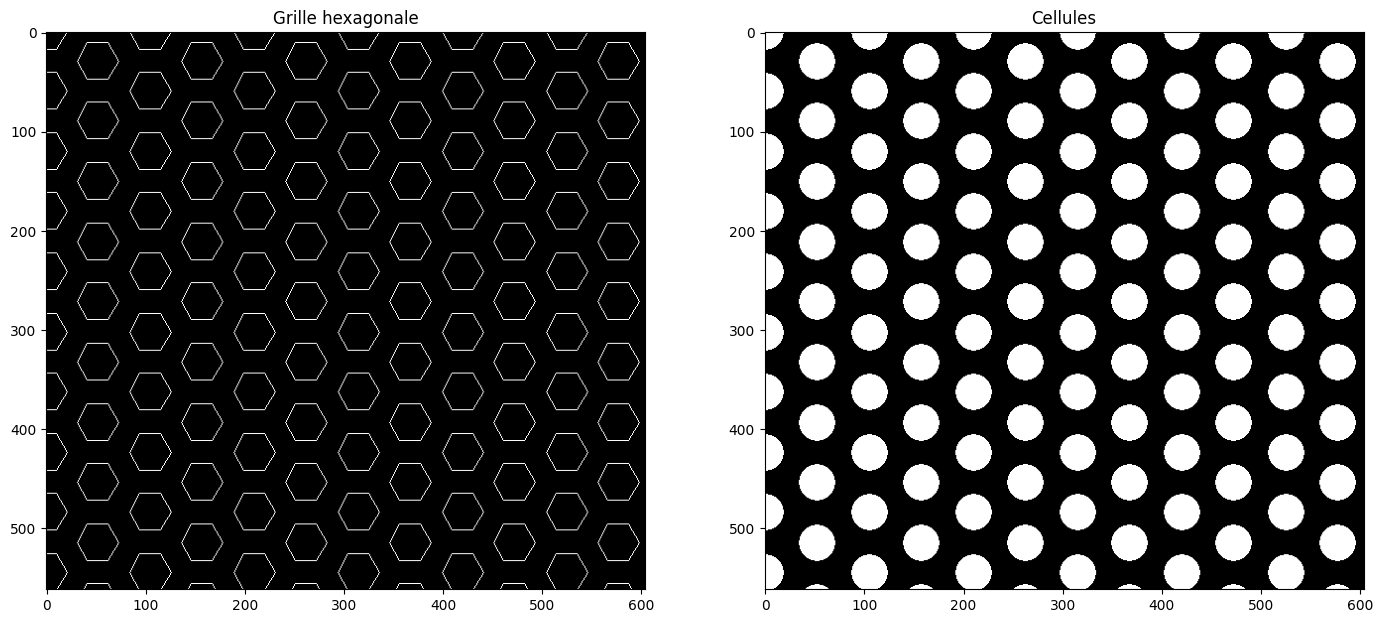

In [81]:
# Cellule de test
colonnes, lignes = im.size

img_check_hex_selection = Image.new(mode='L',size=im.size,color=0)
for c in calcul_hexa_centers(im,taille):
    hexa_surface = extract_hex_points(c,int(taille*rho))
    for p in hexa_surface:
        if p[0]<colonnes and p[0]>=0 and p[1]<lignes and p[1]>=0:
            img_check_hex_selection.putpixel(p,255)

black_image = Image.new(mode='L',size=im.size,color=0)

img_hexagon_grid = hexagon_grid(black_image,taille,rho)

fig,ax = plt.subplots(1,2,figsize = (17,17))

ax[0].imshow(img_hexagon_grid,cmap='gray')
ax[0].set_title('Grille hexagonale')
ax[1].imshow(img_check_hex_selection,cmap = "gray")
ax[1].set_title('Cellules')

#### Carte de distance D5,7,11

Text(0.5, 1.0, 'Carte des distances pour D5,7,11')

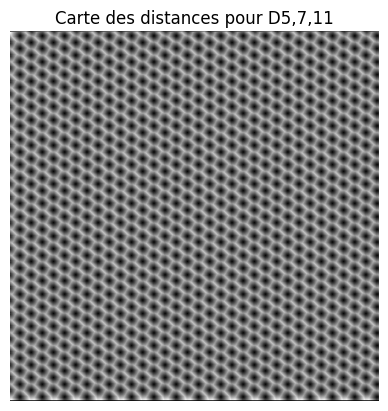

In [82]:
im_bin = Image.new(mode='L',size=(500,500),color=255)
colonnes,lignes = im_bin.size
carte = np.full((lignes,colonnes),10000)

for c in calcul_hexa_centers(im_bin,10):
    if(c[0]<lignes and c[1]<colonnes):
        im_bin.putpixel(c,0)
        carte[c[1]][c[0]]=0

#im.putpixel((4,4),0)
#carte[4][4]=0

mask1= np.array([10000,11,10000,11,7,5,10000,5,0,11,7,10000,10000,11,10000])
mask1=mask1.reshape((5,3))

for x in range(lignes-4):
    for y in range(colonnes-2):
        distances_possibles=[]
        for i in range(5):
            for j in range(3):
                distances_possibles.append(carte[x+i][y+j]+mask1[i][j])
        carte[x+2][y+2]=min(distances_possibles)

carte[0][0]=np.min([carte[0][0],carte[0][1]+1,carte[1][0]+1])
carte[0][colonnes-1]=np.min([carte[0][colonnes-1],carte[0][2]+1,carte[1][colonnes-1]+1])
carte[lignes-1][0]=np.min([carte[lignes-1][0],carte[lignes-2][0]+1,carte[lignes-1][1]+1])
carte[lignes-1][colonnes-1]=np.min([carte[lignes-1][colonnes-1],carte[lignes-2][colonnes-1]+1,carte[lignes-1][colonnes-2]+1])

for y in range (1,colonnes-1):
    carte[0][y]=np.min([carte[0][y],carte[1][y]+1,carte[0][y+1]+1,carte[0][y-1]+1])
    carte[lignes-1][y]=np.min([carte[colonnes-1][y],carte[colonnes-2][y]+1,carte[colonnes-1][y-1]+1,carte[colonnes-1][y+1]+1])
for x in range(1,lignes-1):
    carte[x][0]=np.min([carte[x][0],carte[x-1][0]+1,carte[x+1][0]+1,carte[x][1]+1])


mask2= np.array([10000,11,10000,10000,7,11,0,5,10000,5,7,11,10000,11,10000])
mask2 = mask2.reshape((5,3))

for x in range(lignes-5,-1,-1):
    for y in range(colonnes-3,-1,-1):
        distances_possibles=[]
        for i in range(5):
            for j in range(3):
                distances_possibles.append(carte[x+i][y+j]+mask2[i][j])
        carte[x+2][y] = min(distances_possibles)

#Correction des effets de bords
carte[0][0]=np.min([carte[0][0],carte[0][1]+1,carte[1][0]+1])
carte[0][colonnes-1]=np.min([carte[0][colonnes-1],carte[0][2]+1,carte[1][colonnes-1]+1])
carte[lignes-1][0]=np.min([carte[lignes-1][0],carte[lignes-2][0]+1,carte[lignes-1][1]+1])
carte[lignes-1][colonnes-1]=np.min([carte[lignes-1][colonnes-1],carte[lignes-2][colonnes-1]+1,carte[lignes-1][colonnes-2]+1])
for y in range (1,colonnes-1):
    carte[0][y]=np.min([carte[0][y],carte[1][y]+1,carte[0][y+1]+1,carte[0][y-1]+1])
    carte[lignes-1][y]=np.min([carte[colonnes-1][y],carte[colonnes-2][y]+1,carte[colonnes-1][y-1]+1,carte[colonnes-1][y+1]+1])
for x in range(1,lignes-1):
    carte[x][0]=np.min([carte[x][0],carte[x-1][0]+1,carte[x+1][0]+1,carte[x][1]+1])

new_card = np.zeros((lignes,colonnes))
for i in range(len(carte)):
    for j in range(len(carte[i])):
        if carte[i][j] <=255:
            new_card[i][j] = carte[i][j]
        else:
            new_card[i][j] = 0


plt.imshow(new_card[2:lignes-1,2:colonnes-2],cmap='gray')
plt.axis('off')
plt.title('Carte des distances pour D5,7,11')

## Extraction des minimas du gradient dans chaque cellule

In [83]:
# Retourne les valeurs du gradient au sein d'une cellule

def extract_hex_grad(grad_im,c,taille):
    hex_points = extract_hex_points(c,taille)
    grad_hex = []
    grad_coord = []
    colonnes, lignes = grad_im.size
    for p in hex_points:
        if (p[0]>=0 and p[0]<colonnes and p[1]>=0 and p[1]<lignes):
            grad_hex.append(grad_im.getpixel((p[0],p[1])))
            grad_coord.append((p[0],p[1]))
    return grad_hex,grad_coord

In [84]:
# Retourne les minima du gradient au sein d'une cellule

def extract_hex_grad_min(grad_im,c,taille):
    hex_points = extract_hex_points(c,taille)
    grad_hex = []
    grad_coord = []
    colonnes, lignes = grad_im.size
    for p in hex_points:
        if (p[0]>=0 and p[0]<colonnes and p[1]>=0 and p[1]<lignes):
            grad_hex.append(grad_im.getpixel((p[0],p[1])))
            grad_coord.append((p[0],p[1]))
    grad_hex = np.array(grad_hex)
    if len(grad_hex)>0:
        min_indices = np.where(grad_hex == grad_hex.min())[0] # Prends les coordonnées où le gradient est minimal
        min_coord = [grad_coord[i] for i in min_indices]
        return min_coord
    else:
        return [c]

Text(0.5, 1.0, 'Minima du gradient en blanc')

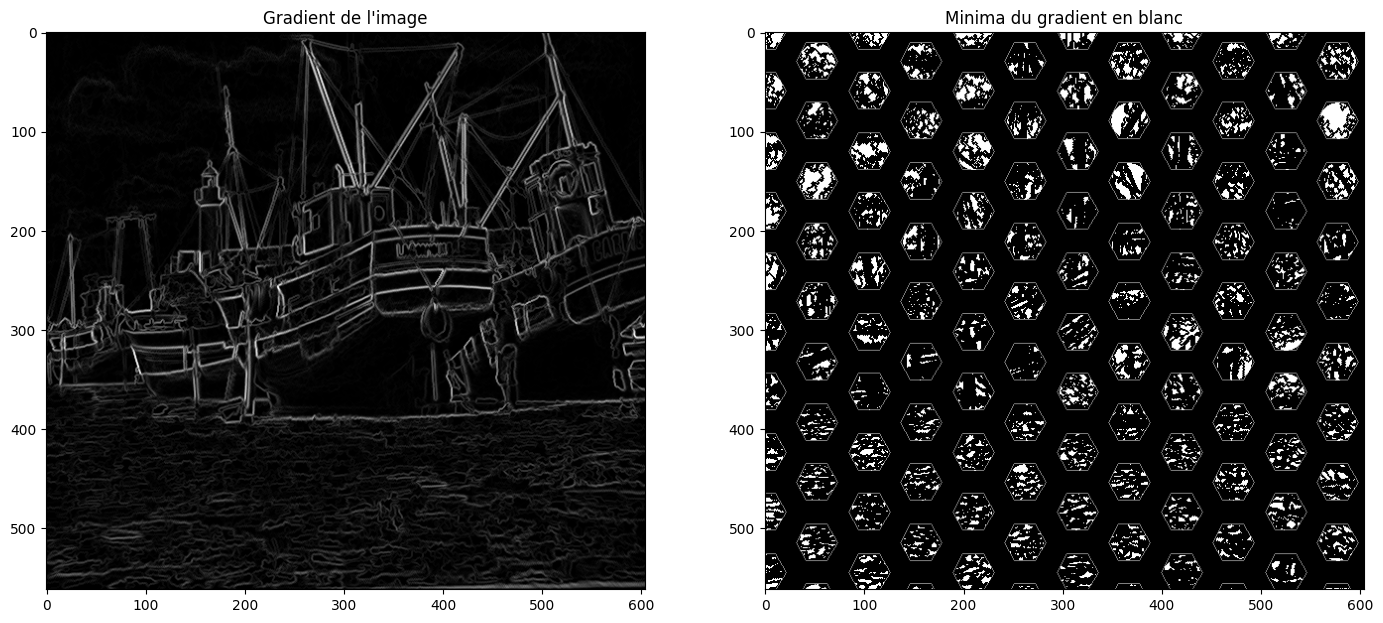

In [85]:
# Cellule de test
s=[]
for c in calcul_hexa_centers(im,taille):
    grad_min = extract_hex_grad_min(im,c,int(taille*rho))
    s.append(grad_min)

colonnes, lignes = im.size

img_selection_marqueur = Image.new(mode='L',size=im.size,color=0)
img_selection_marqueur = hexagon_grid(Image.fromarray(np.uint8(img_selection_marqueur)),taille,rho)

for hexagon in s:
    for i in range(len(hexagon)):
        xy = hexagon[i]
        if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
            img_selection_marqueur.putpixel(xy,255)

fig,ax = plt.subplots(1,2,figsize = (17,17))

ax[0].imshow(im,cmap='gray')
ax[0].set_title("Gradient de l'image")
ax[1].imshow(img_selection_marqueur,cmap = "gray")
ax[1].set_title('Minima du gradient en blanc')

## Etiquetage en composantes connexes

Le voisinage d'un pixel est, pour notre projet, sa 8-connexité

In [86]:
def est_voisin(x_i,y_i,x_j,y_j):
    voisin = False
    if ((x_j==x_i+1) or(x_j==x_i-1) or (x_i==x_j)) and ((y_j==y_i+1) or y_j==y_i-1 or y_j==y_i):
        voisin = True
    return voisin

In [87]:
# Ici, pour chaque hexagone, on prend les minima du gradient
def selection_marqueurs(grad_im,taille,rho):
    marqueurs = []
    centres = calcul_hexa_centers(grad_im,taille)
    for c in centres:
        hex = extract_hex_grad_min(grad_im,c,int(rho*taille))
        comp = []
        # Puis pour chaque minimum, on regarde si ses voisins appartiennent à une composante connexe
        while len(hex)>0:
            CC=[hex[0]]
            bl=[hex[0]] #bl est une blacklist dans laquelle on met les sommets étiquetés pour qu'on ne les regarde plus
            Attente=[]
            for s in hex: #On regarde tous les autres minimas pour trouver ceux voisins à celui dans CC
                if s not in bl:
                    x_0,y_0 = hex[0]
                    x_s,y_s = s
                    if est_voisin(x_0,y_0,x_s,y_s):
                        Attente.append(s)
                        bl.append(s)
            while len(Attente)>0: #Même chose, on cherche les voisins parmi ceux qui sont voisins à hex[0]
                sprime=Attente[0]
                for s in hex:
                    if s not in bl:
                        x_0,y_0 = sprime
                        x_s,y_s = s
                        if est_voisin(x_0,y_0,x_s,y_s):
                            Attente.append(s)
                            bl.append(s)
                Attente.remove(sprime)
                CC.append(sprime)
            comp.append(CC)
            for b in bl:
                hex.remove(b)
        max_surface = max(comp, key=len) # On prend la plus grande surface à la fin
        marqueurs.append(max_surface)
    return marqueurs

Text(0.5, 1.0, 'Marqueurs choisis')

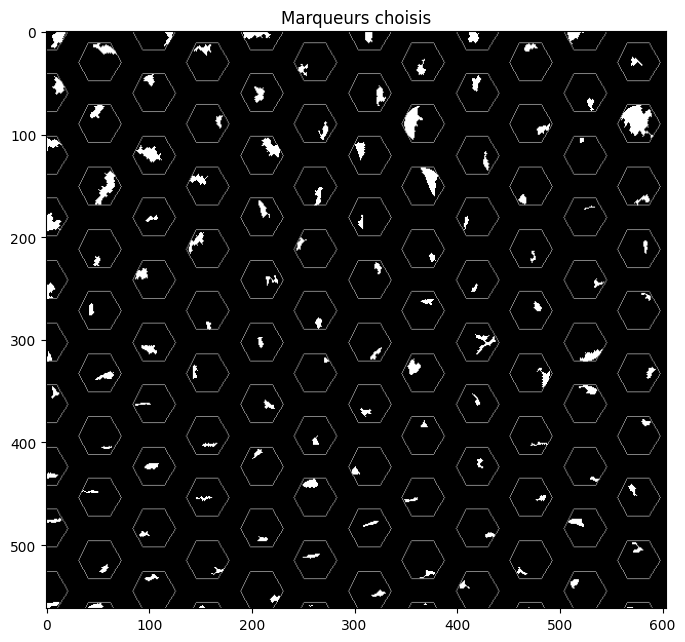

In [88]:
# Cellule de test
s=selection_marqueurs(im,taille,rho)

new_temp_img = Image.new(mode="L",size=img_selection_marqueur.size,color=0)

temp_hexa = hexagon_grid(Image.fromarray(np.uint8(new_temp_img)),taille,rho)
colonnes,lignes = im.size
for grad_coord in s:
    for xy in grad_coord:
        if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
            temp_hexa.putpixel(xy,255)

fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(temp_hexa, cmap='gray')
ax.set_title("Marqueurs choisis")

## Carte des distances

In [89]:
def binary_grad_min(im,s):
    colonnes,lignes = im.size
    bin_img = np.ones((lignes,colonnes))
    for grad_coord in s:
        for xy in grad_coord:
            if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
                bin_img[xy[1]][xy[0]]=0
    return bin_img

Text(0.5, 1.0, 'Carte des distances aux marqueurs')

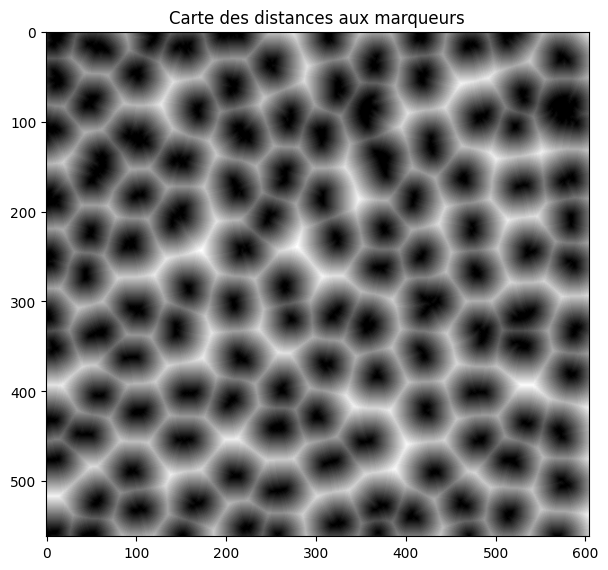

In [90]:
# Cellule de test
carte_distance = binary_grad_min(im,s)
carte_distance = ndimage.distance_transform_edt(carte_distance)
carte_distance = Image.fromarray(np.uint8(carte_distance))

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(carte_distance, cmap='gray')
ax.set_title("Carte des distances aux marqueurs")

## Régularisation spatiale du gradient

In [91]:
def regularisation_spatiale(grad_im,distance_carte,k,taille):
    colonnes, lignes = grad_im.size
    new_grad_im = Image.new(mode="L",size=(colonnes,lignes),color=0)
    for i in range(lignes):
        for j in range(colonnes):
            new_pixel = grad_im.getpixel((j,i))+(k*(2/taille)*distance_carte[i][j])
            new_grad_im.putpixel((j,i),int(new_pixel))
    return new_grad_im

Text(0.5, 1.0, 'Gradient régularisé avec k=10')

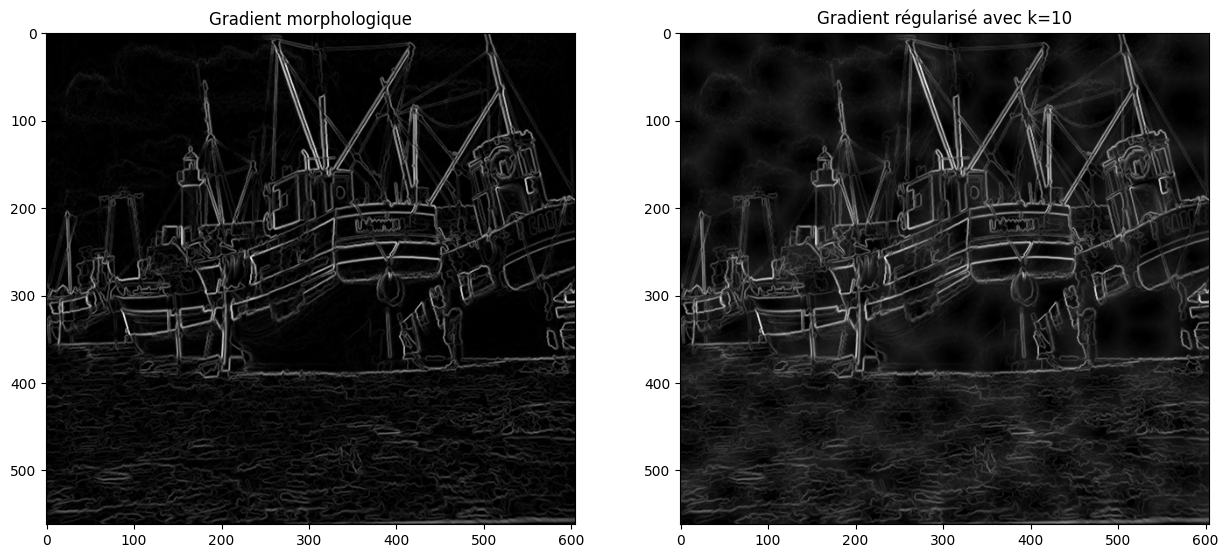

In [92]:
## Cellule de test
carte_distance = binary_grad_min(im,s)
carte_distance = ndimage.distance_transform_edt(carte_distance)
grad_regularized = regularisation_spatiale(im,carte_distance,k,taille)

fig,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(im, cmap='gray')
ax[0].set_title("Gradient morphologique")
ax[1].imshow(grad_regularized, cmap='gray')
ax[1].set_title("Gradient régularisé avec k=10")

## Application du Watershed

In [93]:
def labelisation(im,marqueurs):
    colonnes,lignes = im.size
    mark_img_binary = np.zeros((lignes,colonnes),dtype=np.uint8)
    for m in marqueurs:
        for p in m:
            if p[0]<colonnes and p[0]>=0 and p[1]<lignes and p[1]>=0:
                mark_img_binary[p[1]][p[0]]=1
    return ndimage.label(mark_img_binary)[0]

Text(0.5, 1.0, 'Waterpixels pour k=10, rho=0.6, taille=35')

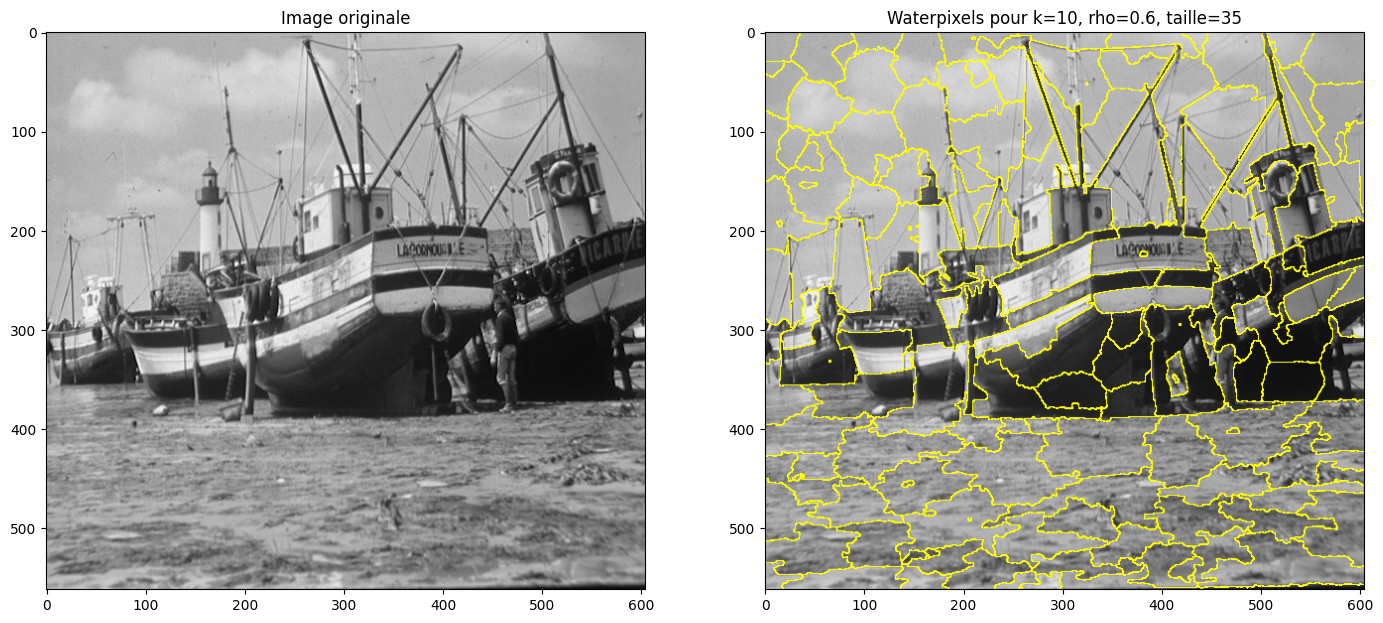

In [95]:
## Cellule de test
mark_img_binary = labelisation(im,s)
grad_regularized_np = np.array(grad_regularized)

ws = watershed(grad_regularized_np, mark_img_binary,watershed_line = True)
test = mark_boundaries(img_as_float(img),ws)

fig,ax = plt.subplots(1,2,figsize=(17,17))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Image originale")
ax[1].imshow(test)
ax[1].set_title("Waterpixels pour k=10, rho=0.6, taille=35")